# Objective
The objetive of this notebook is to load the previously stored models and visualize the forecasts of cement production data. 

# Description of the data
The dataset is quaterly cement production data.

# Imports, configuration and constants

In [6]:
import matplotlib.pyplot as plt
import mlflow
import pandas as pd

import utils as ut

In [3]:
import importlib
importlib.reload(ut)

<module 'utils' from '/home/santiagopalmero/repos/fpp3package/python/mlflow/utils.py'>

In [4]:
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

In [5]:
PLOT_TITLE = "AUS cement production"
PLOT_YLABEL = "Cement"
PLOT_XLABEL = "Quarter"

PLOT_KWARGS = {
    "title": PLOT_TITLE,
    "ylabel": PLOT_YLABEL,
    "xlabel": PLOT_XLABEL,
}

# Load data

In [7]:
ts_train = ut.read_csv_series("data/ts_train.csv")
ts_test = ut.read_csv_series("data/ts_test.csv")

In [8]:
ts_train.index = pd.to_datetime(ts_train.index)
ts_train = ts_train.asfreq('QS-OCT')

ts_test.index = pd.to_datetime(ts_test.index)
ts_test = ts_test.asfreq('QS-OCT')

# Set experiment

In [9]:
mlflow.set_experiment("Cement_Forecasting")

<Experiment: artifact_location='file:///home/santiagopalmero/repos/fpp3package/python/mlflow/mlruns/570366757150847423', creation_time=1701436591943, experiment_id='570366757150847423', last_update_time=1701436591943, lifecycle_stage='active', name='Cement_Forecasting', tags={'mlflow.note.content': 'Project about cement production forecasting. This '
                        'experiment contains several forecasting models.',
 'project_name': 'forecasting'}>

# Load models from run ids


In [26]:
arima_uri = "runs:/3f23ee0fe81c4d548a4133ed2b056f19/SARIMAX_model"
ets_uri = "runs:/bc15d23567c14077bf21a7e2237cfa8c/ETS_model"
prophet_uri = "runs:/1fdd2b7be1294ac29a7522a23a92c59d/Prophet_model"

arima_pyfunc = mlflow.pyfunc.load_model(model_uri=arima_uri)
ets_pyfunc = mlflow.pyfunc.load_model(model_uri=ets_uri)
prophet_pyfunc = mlflow.pyfunc.load_model(model_uri=prophet_uri)

# Forecasting test

## ARIMA

In [29]:
# Prediction dataframes for a TimeSeriesModel must have exactly one row and 
# include columns called start and end
start = pd.to_datetime(ts_test.index[0])
end = pd.to_datetime(ts_test.index[-1])

prediction_data = pd.DataFrame({"start": start, "end": end}, index=[0])
ts_arima_h = arima_pyfunc.predict(prediction_data)
ts_arima_h

2008-01-01    2316.867722
2008-04-01    2489.894004
2008-07-01    2531.558849
2008-10-01    2482.209738
2009-01-01    2290.261027
2009-04-01    2473.175645
2009-07-01    2502.579827
2009-10-01    2451.309548
2010-01-01    2255.029916
2010-04-01    2455.212408
Freq: QS-OCT, Name: predicted_mean, dtype: float64

Both for ARIMA and ETS with statsmodels flavour we can't get with predict the confidence interval of the prediction. What we could do is to load the underlying model from the pyfunc. Obviously this would not be valid if we wanted to directly serve the model.

In [38]:
# This function is bugged and does not return the base model
# arima_pyfunc.unwrap_python_model()

# We can extract the model accessing to a hidden attribute
sm_wrapper = arima_pyfunc._model_impl
res = sm_wrapper.statsmodels_model

ts_arima_h, ts_arima_h_lower, ts_arima_h_upper = ut.sm_arima_predict_w_interval(
    res, 
    ts_test,
)

## ETS


In [30]:
ts_ets_h = ets_pyfunc.predict(prediction_data)
ts_ets_h

2008-01-01    2253.187112
2008-04-01    2490.747411
2008-07-01    2573.875726
2008-10-01    2540.758414
2009-01-01    2253.187112
2009-04-01    2490.747411
2009-07-01    2573.875726
2009-10-01    2540.758414
2010-01-01    2253.187112
2010-04-01    2490.747411
Freq: QS-OCT, dtype: float64

In [44]:
sm_wrapper = ets_pyfunc._model_impl
res = sm_wrapper.statsmodels_model

ts_ets_h, ts_ets_h_lower, ts_ets_h_upper = ut.sm_ets_predict_w_interval(
    res, 
    ts_test,
)

## Prophet

In [ ]:
df_future = (
    pd.DataFrame({
        'ds': ts_test.index.tolist(),
    })
    .reset_index(drop=True)
)

df_predict = prophet_pyfunc.predict(df_future)

ts_pro_h = pd.Series(
    df_predict['yhat'].values, 
    index=df_predict['ds'],
)

ts_pro_h_lower = pd.Series(
    df_predict['yhat_lower'].values, 
    index=df_predict['ds'],
)

ts_pro_h_upper = pd.Series(
    df_predict['yhat_upper'].values, 
    index=df_predict['ds'],
)

# Visualizing forecast

In [48]:
labels = ["arima", "ets", "prophet", "real",]

ts_hs = [
    ts_arima_h,
    ts_ets_h,
    ts_pro_h,
    ts_test,
]

ts_hs_lower = [
    ts_arima_h_lower,
    ts_ets_h_lower,
    ts_pro_h_lower,
    ts_test,
]

ts_hs_upper = [
    ts_arima_h_upper,
    ts_ets_h_upper,
    ts_pro_h_upper,
    ts_test,
]


In [49]:
ts_with_hs = list()
ts_with_hs_lower = list()
ts_with_hs_upper = list()

for i in range(len(ts_hs)):
    ts_with_h, ts_with_h_lower, ts_with_h_upper = ut.join_forecast_to_series(
        ts_train,
        ts_train.index,
        ts_hs[i],
        ts_hs_lower[i],
        ts_hs_upper[i],
    )
    ts_with_hs.append(ts_with_h)
    ts_with_hs_lower.append(ts_with_h_lower)
    ts_with_hs_upper.append(ts_with_h_upper)

/home/santiagopalmero/repos/fpp3package/python/mlflow/utils.py:110: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


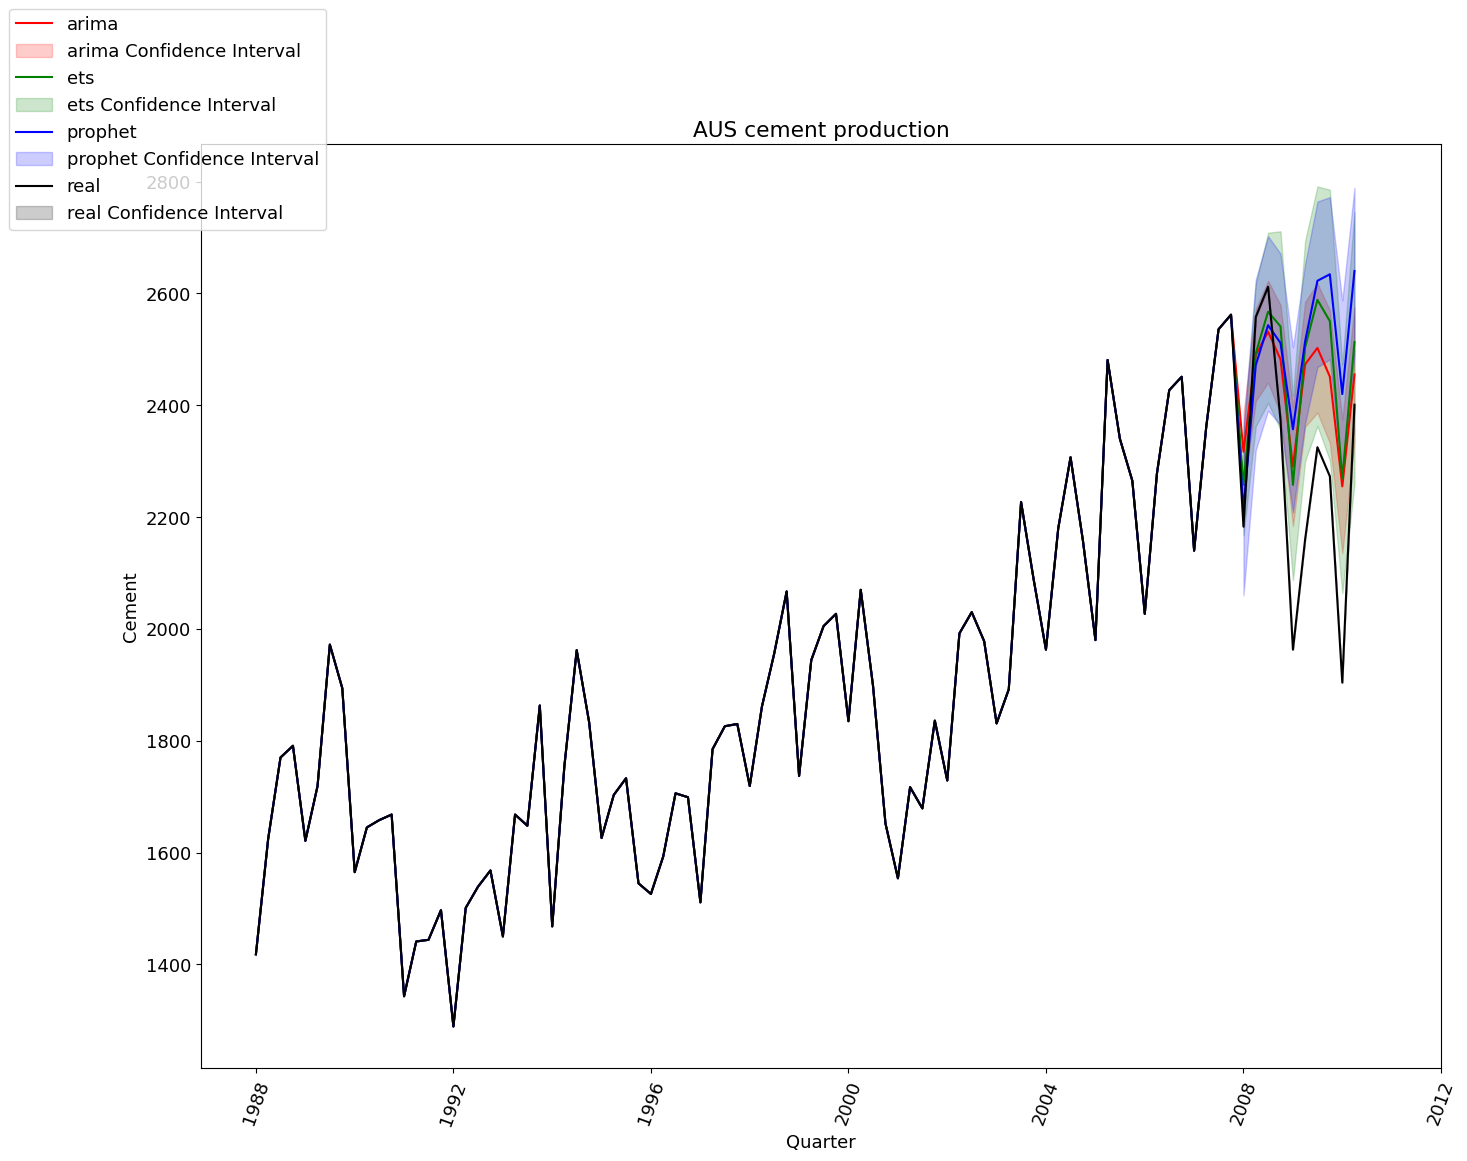

In [50]:
ut.plot_multiple_ts(
    ts_with_hs,
    lower_ci_list=ts_with_hs_lower,
    upper_ci_list=ts_with_hs_upper,
    labels=labels,
    **PLOT_KWARGS,
)